##### Concurrency 2021/2022 - Computer Science
# Lecture 4 - Grover's Algorithm

1. [Grover's Algorithm](#Grover)
   1. [Unstructured search](#unstructured-search)
   2. [Oracle](#oracle_intro)
   3. [Amplitude Amplification](#amplitude_amp)
2. [Grover's algorithm with 2 qubits](#grover2)
3. [Grover's algorithm with 3 qubits](#grover3)

In [22]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute
from qiskit.tools.visualization import plot_histogram, plot_distribution
import matplotlib.pyplot as plt
import numpy as np

##### Function for executing circuits

In [51]:
def execute_circuit(qc, shots=1024, decimal=False, reversed=False):
    
    #define backend
    device = Aer.get_backend('qasm_simulator')
    #get counts
    counts = execute(qc, device, shots=shots).result().get_counts()
    
    if decimal:
        if reversed:
            counts = dict((int(a[::-1],2),b) for (a,b) in counts.items())
        else:
            counts = dict((int(a,2),b) for (a,b) in counts.items())
    else:
        if reversed:
            counts = dict((a[::-1],b) for (a,b) in counts.items())
        else:
            counts = dict((a,b) for (a,b) in counts.items())

    return counts

## 1. Grover's algorithm <a id="grover"></a>

Grover's algorithm is one of the most powerful quantum algorithms. The algorithm is known for a quadratic speed up in searching for an element in an **unstructured database**. 

However, Grover's algorithm can be generalized to a variety of problems:
* Finding minimum/maximum/mean 
* Collision problem 
* Satisfiability 
* Optimization in general. 
* Any problem that can be restated as a search problem! BUT, it should be unstructured otherwise classical computers can do better. Specifically, search solutions to NP problems (where a good solution is hard to find, but easily verified).

### Unstructured Search <a id="unstructured-search"></a>

Suppose you have an array of $N$ items. Consider that $w$ for winner is the element we want to find. 

![image1](images/list.png)

Classic $\quad \Rightarrow \quad \mathcal{O}(N)$

Quantum $\quad \Rightarrow \quad \mathcal{O}(\sqrt{N})$

### Oracle

Notice that we want to exploit the superposition principle, therefore, all entries in the above database will happen at the same time! Thus, for us, the database is composed by all computational basis states our qubits can be in.

The oracle $U_w$ adds a negative phase to the solution states i.e. for any state $|x\rangle$ in the computational basis corresponding to the winner:

$$
U_\omega|x\rangle = \bigg\{
\begin{aligned}
\phantom{-}|x\rangle \quad \text{if} \; x \neq \omega \\
-|x\rangle \quad \text{if} \; x = \omega \\
\end{aligned}
$$

This oracle will be a diagonal matrix, where the entry that correspond to the marked item will have a negative phase. For example, if we have three qubits and $\omega = \text{101}$, our oracle will have the matrix:

$$
U_\omega = 
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
\end{bmatrix}
\begin{aligned}
\\
\\
\\
\\
\\
\leftarrow \omega = \text{101}\\
\\
\\
\\
\end{aligned}
$$


In many computational problems it’s difficult to _find_ a solution, but relatively easy to _verify_ a solution (NP problems). For instance, **chess**. For these problems, we can create a function $f$ that takes a proposed solution $x$, the position of pieces in the board and returns $f(x) = 0$ if $x$ is not a solution ($x \neq \omega$) and $f(x) = 1$ for a valid solution ($x = \omega$). The oracle is represented as:

$$
U_\omega|x\rangle = (-1)^{f(x)}|x\rangle
$$

and the oracle's matrix will be a diagonal matrix of the form:

$$
U_\omega = 
\begin{bmatrix}
(-1)^{f(0)} &   0         & \cdots &   0         \\
0           & (-1)^{f(1)} & \cdots &   0         \\
\vdots      &   0         & \ddots & \vdots      \\
0           &   0         & \cdots & (-1)^{f(2^n-1)} \\
\end{bmatrix}
$$

### How to construct the oracle circuit? 

Remember that computation is reversible, thus we need an ancilla to store the result of the function! 


Similar to Deutsch-Jozsa, we initialize the 'output' qubit in the state $|{-}\rangle$, and the phase kickback effect do the rest.
</p><p>  

![image1](images/function.png)


### Amplitude Amplification <a id="amplitude_amp"></a>

* We start always with the uniform superposition over the basis states. That is, if we have an array with $N$ elements, we need $n \sim log(N)$ qubits to represent all possible basis states. 

\begin{align*}
    2^n &= N \\
    n &\sim log(N)
\end{align*} 

We can represent the uniform superposition state as:

$$|s \rangle = \frac{1}{\sqrt{N}} \sum_{x = 0}^{N -1} | x
\rangle$$

Now, the goal is to find a routine that amplifies the probability of measuring the winner state! 


This algorithm has a nice geometrical interpretation in terms of two reflections, which generate a rotation in a two-dimensional plane. The only two special states we need to consider are the winner $| w \rangle$ and the uniform superposition $| s \rangle$. These two vectors span a two-dimensional plane in the vector space $\mathbb{C}^N.$ They are not quite perpendicular because $| w \rangle$ occurs in the superposition with amplitude $N^{-1/2}$ as well.
We can, however, introduce an additional state $|s'\rangle$ that is in the span of these two vectors, which is perpendicular to $| w \rangle$ and is obtained from $|s \rangle$ by removing $| w \rangle$ and
rescaling. 

**Step 1**: The amplitude amplification procedure starts out in the uniform superposition $| s \rangle$, which is easily constructed from $| s \rangle = H^{\otimes n} | 0 \rangle^n$.

![image2](images/step1.png)


The left graphic corresponds to the two-dimensional plane spanned by perpendicular vectors $|w\rangle$ and $|s'\rangle$ which allows to express the initial state as $|s\rangle = \sin \theta | w \rangle + \cos \theta | s' \rangle,$ where $\theta = \arcsin \langle s | w \rangle = \arcsin \frac{1}{\sqrt{N}}$. The right graphic is a bar graph of the amplitudes of the state $| s \rangle$.

**Step 2**: We apply the oracle reflection $U_f$ to the state $|s\rangle$.

![image3](images/step2.png)

Geometrically this corresponds to a reflection of the state $|s\rangle$ about $|s'\rangle$. This transformation means that the amplitude in front of the $|w\rangle$ state becomes negative, which in turn means that the average amplitude (indicated by a dashed line) has been lowered.

**Step 3**: We now apply an additional reflection ($U_s$) about the state $|s\rangle$: $U_s = 2|s\rangle\langle s| - \mathbb{1}$. This transformation maps the state to $U_s U_f| s \rangle$ and completes the transformation. 

![image4](images/step3.png)

Two reflections always correspond to a rotation. The transformation $U_s U_f$ rotates the initial state $|s\rangle$ closer towards the winner $|w\rangle$. The action of the reflection $U_s$ in the amplitude bar diagram can be understood as a reflection about the average amplitude. Since the average amplitude has been lowered by the first reflection, this transformation boosts the negative amplitude of $|w\rangle$ to roughly three times its original value, while it decreases the other amplitudes. We then go to **step 2** to repeat the application. This procedure will be repeated several times to zero in on the winner. 

After $t$ steps we will be in the state $|\psi_t\rangle$ where: $| \psi_t \rangle = (U_s U_f)^t  | s \rangle.$

How many times do we need to apply the rotation? It turns out that roughly $\sqrt{N}$ rotations suffice. Why? 

![image5](images/full_circuit.png)

## Grover's algorithm with 2 qubits <a id="grover2"></a>

Let's suppose we want to find the state $|11\rangle$.
Build the Grover's algorithm !

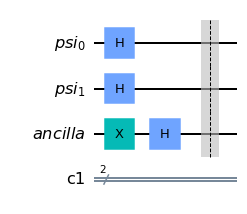

In [8]:
qr = QuantumRegister(2,name="psi")
ancilla = QuantumRegister(1,name="ancilla")
cr = ClassicalRegister(2)

qc = QuantumCircuit(qr,ancilla,cr)

#uniform superposition qr
qc.h(qr)

#|-> state ancilla
qc.x(ancilla)
qc.h(ancilla)

qc.barrier() 

qc.draw(output="mpl")

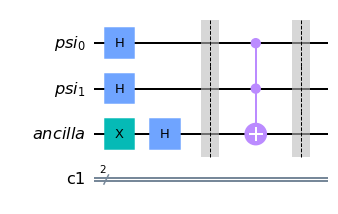

In [9]:
#oracle 

qc.ccx(qr[0],qr[1],ancilla)

qc.barrier()

qc.draw(output="mpl")

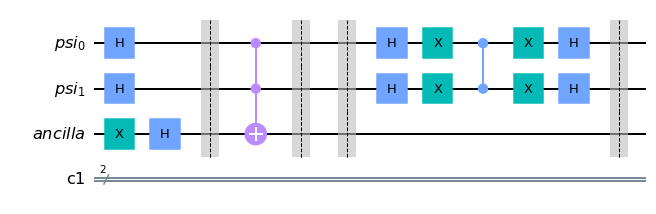

In [10]:
#diffusion 

qc.barrier()
qc.h(qr)
qc.x(qr)
qc.cz(qr[0],qr[1])
qc.x(qr)
qc.h(qr)

qc.barrier()

qc.draw(output="mpl")


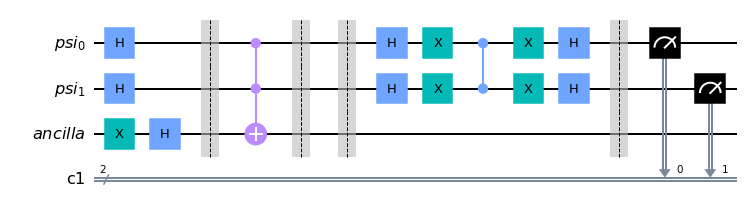

In [11]:
qc.measure(qr,cr)

qc.draw(output="mpl")


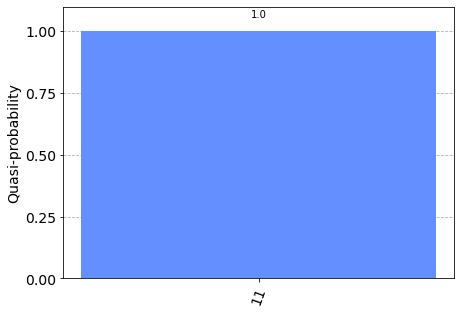

In [15]:
counts = execute_circuit(qc, shots=1, reversed=True)
plot_distribution(counts)

#### Define the oracle 

In [43]:
def oracle(qr, ancilla):

    qc.barrier()
    return qc

In [ ]:
qr = QuantumRegister(2)
ancilla = QuantumRegister(1)
qc = QuantumCircuit(qr,ancilla)
qc = qc.compose(oracle(qr,ancilla))
qc.draw(output="mpl")

#### Define the diffusion operator 

In [34]:
def diffusion_operator(qr, ancilla):

    qc = QuantumCircuit(qr,ancilla)
    
    qc.barrier()
    
    return qc 


In [ ]:
qr = QuantumRegister(2)
ancilla = QuantumRegister(1)
qc = QuantumCircuit(qr,ancilla)
qc = qc.compose(diffusion_operator(qr,ancilla))
qc.draw(output="mpl")

#### Prepare initial quantum state

In [ ]:
qr=QuantumRegister(2)
ancilla=QuantumRegister(1)
cr=ClassicalRegister(2)
qc=QuantumCircuit(qr,ancilla,cr)

#sobreposicação uniforme em qr

#prepara ancilla no estado |-> 


qc.draw(output="mpl")

#### Apply $j$ iterations of Grover's operator

In [ ]:
n_qubits = 2
elements = 2**n_qubits

iterations= int(np.floor(np.pi/4 * np.sqrt(elements)))

for j in range(iterations):
    qc = qc.compose(oracle(qr,ancilla))
    qc = qc.compose(diffusion_operator(qr,ancilla))

qc.measure(qr,cr)
qc.draw(output="mpl")
    

In [ ]:
counts = execute_circuit(qc)
plot_distribution(counts)

## Grover's algorithm with 3 qubits <a id="grover3"></a>  


Let's suppose we want to find the state $|111\rangle$.
Build the Grover's algorithm !

In [16]:
def oracle(qr, ancilla):
    
    qc = QuantumCircuit(qr,ancilla)
    qc.mct([qr[0],qr[1],qr[2]],ancilla)


    qc.barrier()
    return qc

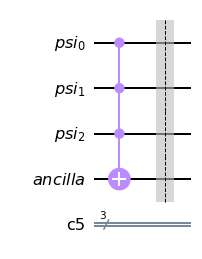

In [20]:
qr=QuantumRegister(3,name="psi")
ancilla=QuantumRegister(1,name="ancilla")
cr=ClassicalRegister(3)
qc=QuantumCircuit(qr,ancilla,cr)

qc = qc.compose(oracle(qr,ancilla))

qc.draw(output="mpl")

In [21]:
def diffusion_operator(qr, ancilla):

    qc = QuantumCircuit(qr,ancilla)

    qc.barrier()
    qc.h(qr)
    qc.x(qr)
    qc.ccz(qr[0],qr[1],qr[2])
    qc.x(qr)
    qc.h(qr)

    qc.barrier()

    return qc 

#### Prepare the initial state

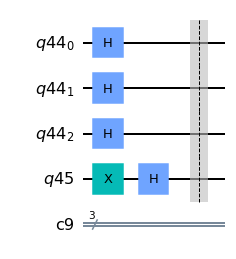

In [30]:
qr=QuantumRegister(3)
ancilla=QuantumRegister(1)
cr=ClassicalRegister(3)
qc =QuantumCircuit(qr,ancilla,cr)

qc.h(qr)
qc.x(ancilla)
qc.h(ancilla)
qc.barrier()

qc.draw(output="mpl")

#### Apply $j$ iterations of Grover operator 

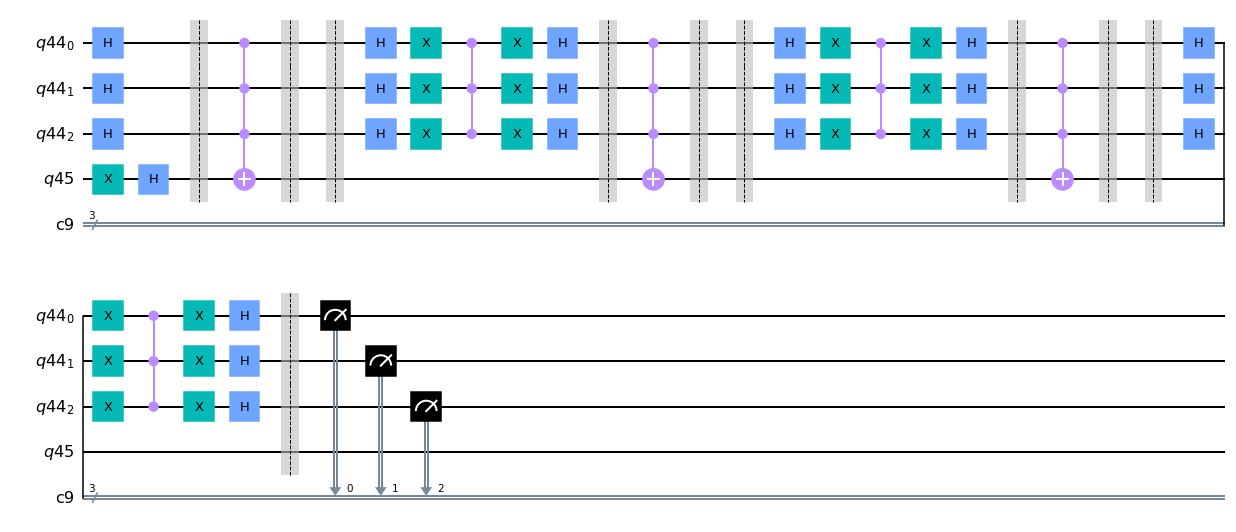

In [31]:
iterations=3
for j in range(iterations):
    qc = qc.compose(oracle(qr,ancilla))
    qc = qc.compose(diffusion_operator(qr,ancilla))

qc.measure(qr,cr)
qc.draw(output="mpl")

#### Execute the circuit

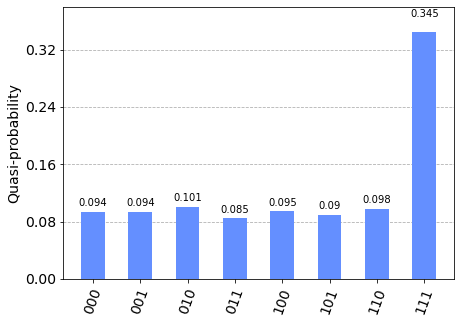

In [32]:
counts = execute_circuit(qc)
plot_distribution(counts)

## Grover's Algorithm with 5 qubits 

z gate para construir difusor 

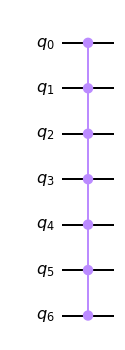

In [25]:
##control == 0 

from qiskit.circuit.library import ZGate, MCXGate

circuit = QuantumCircuit(7)
c6z = ZGate().control(6,ctrl_state="111111")
circuit = circuit.compose(c6z)
circuit.draw(output="mpl")

equivalente a multi control toffoli gate (tambem podemos usar esta estrategia para construir oraculo)

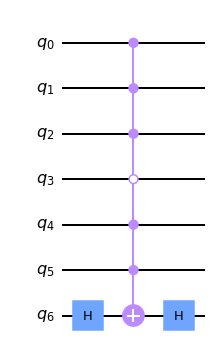

In [26]:
qc =QuantumCircuit(7)

#MCXGate(n_qubits_controlo, ctrl_state)
c6z = MCXGate(6,ctrl_state="110111")

qc.h(6)
qc = qc.compose(c6z)
qc.h(6)

qc.draw(output="mpl")

In [27]:
def oracle(qr, ancilla, solution=None):
    
    qc = QuantumCircuit(qr,ancilla)
    cx_gate = MCXGate(len(qr),ctrl_state=solution)
    qc = qc.compose(cx_gate)
    
    qc.barrier()
    return qc

In [45]:
def diffusion_operator(qr, ancilla, n_qubits):

    qc = QuantumCircuit(qr,ancilla)

    qc.h(qr)
    qc.x(qr[-1])
    cz = ZGate().control(n_qubits-1,ctrl_state="0"*(n_qubits-1))
    qc = qc.compose(cz)
    qc.x(qr[-1])

    qc.h(qr)

    #qc.x(qr)

    #ou
    '''
    qc.x(qr)
    cz = ZGate().control(5,ctrl_state="1"*n_qubits)
    qc = qc.compose(cz)
    qc.x(qr)
    qc.h(qr)
    '''
    qc.barrier()
    
    return qc 

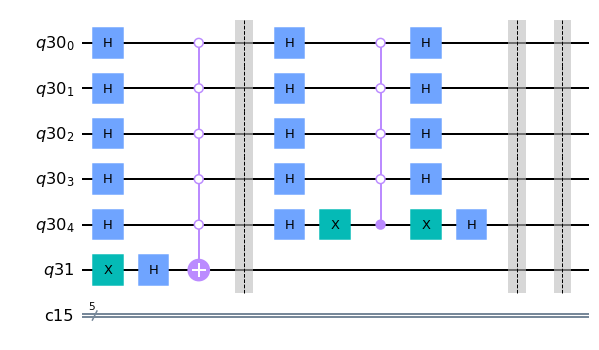

In [46]:
n_qubits = 5

qr=QuantumRegister(5)
ancilla=QuantumRegister(1)
cr=ClassicalRegister(5)

solution1 = "00000"

qc = QuantumCircuit(qr,ancilla,cr)
qc.h(qr)

qc.x(ancilla)
qc.h(ancilla)

qc = qc.compose(oracle(qr,ancilla, solution=solution1))
qc = qc.compose(diffusion_operator(qr,ancilla, n_qubits=5))



qc.barrier()
qc.draw(output="mpl")

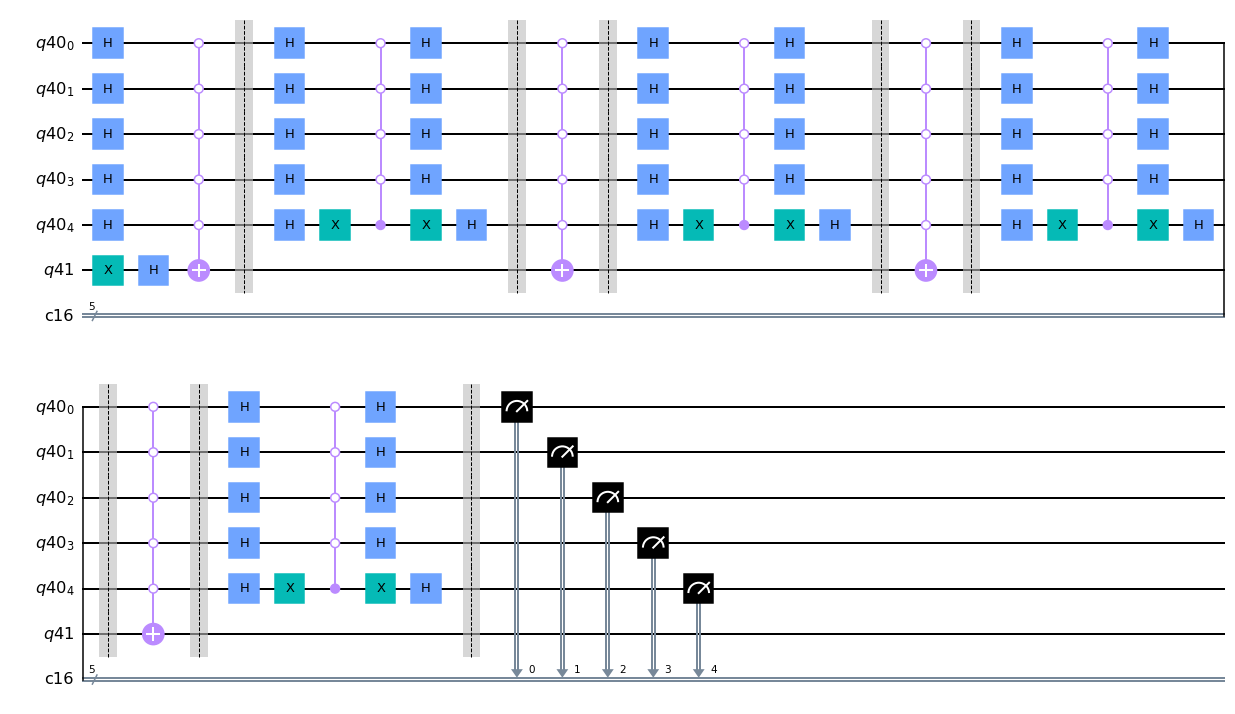

In [53]:
n_qubits = 5
elements = 2**n_qubits

qr=QuantumRegister(5)
ancilla=QuantumRegister(1)
cr=ClassicalRegister(5)

qc = QuantumCircuit(qr,ancilla,cr)
qc.h(qr)

qc.x(ancilla)
qc.h(ancilla)

solution = "00000"
iterations= int(np.floor(np.pi/4 * np.sqrt(elements)))

for j in range(iterations):
    qc = qc.compose(oracle(qr,ancilla,solution=solution))
    qc = qc.compose(diffusion_operator(qr,ancilla,n_qubits))

qc.measure(qr,cr)
qc.draw(output="mpl")

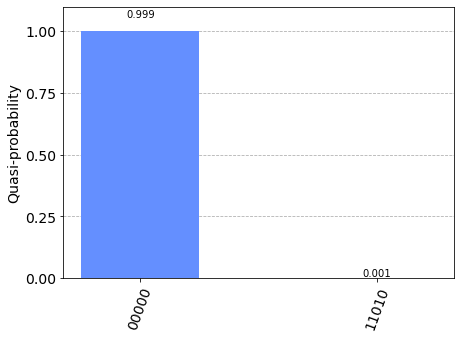

In [54]:
counts = execute_circuit(qc, shots=1024)
plot_distribution(counts)

## Grover's Algorithm with multiple solutions 

#### 3 qubits 
solutions $|010\rangle$ and $|100\rangle$

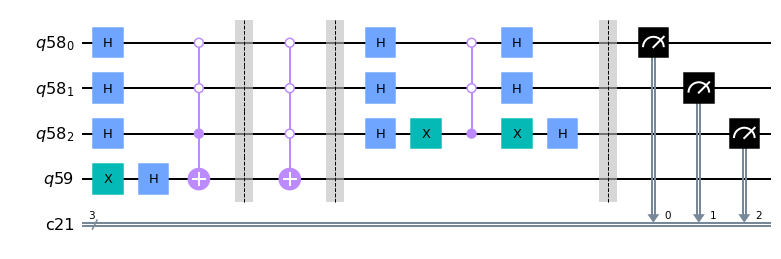

In [59]:
n_qubits = 3
elements = 2**n_qubits
solutions = ["100", "000"]

qr=QuantumRegister(n_qubits)
ancilla=QuantumRegister(1)
cr=ClassicalRegister(n_qubits)

qc = QuantumCircuit(qr,ancilla,cr)
qc.h(qr)

qc.x(ancilla)
qc.h(ancilla)

iterations= int(np.floor(np.pi/4 * np.sqrt(elements/len(solutions))))

for j in range(iterations):
    for solution in solutions:
        qc = qc.compose(oracle(qr,ancilla,solution=solution))

    qc = qc.compose(diffusion_operator(qr,ancilla,n_qubits))

qc.measure(qr,cr)
qc.draw(output="mpl")

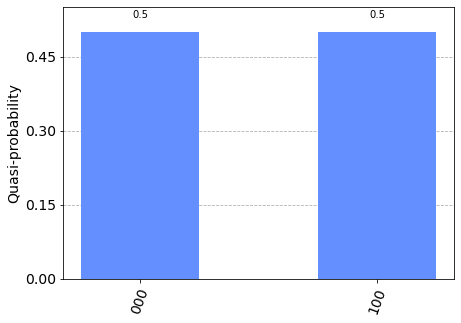

In [63]:
counts = execute_circuit(qc, shots=1024)
plot_distribution(counts)